## Librerías

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression

## Data

In [2]:
# Time: 4 seconds
df_inmuebles = pd.read_csv('../Data/inmuebles_full.csv')

In [3]:
# Create the geometry of the point - from longitud and latitud columns
df_inmuebles['geometry'] = gpd.points_from_xy(x=df_inmuebles['longitud'], y=df_inmuebles['latitud'])

# Create a new variable precio por m2
df_inmuebles['precio_m2'] = df_inmuebles['precio'] / df_inmuebles['area']

# Make it a GeoDataFrame
df_inmuebles = gpd.GeoDataFrame(df_inmuebles, geometry='geometry')

# Filtrar filas sin habitaciones, al ser una de las variables claves no se analizan posibles imputaciones para no dañar la muestra
df_inmuebles = df_inmuebles[~df_inmuebles['habitaciones'].isna()]

# Habitaciones como entero
df_inmuebles['habitaciones'] = df_inmuebles['habitaciones'].astype('int64')

# Solo negocios de venta
df_inmuebles = df_inmuebles[df_inmuebles['tiponegocio'] == 'venta']

# Drop useless columns
df_inmuebles.drop(['latitud', 'longitud', 'fecha_creacion', 'direccion', 'tiponegocio'], axis=1, inplace=True)

# Filtrar las filas con 0 habitaciones y más de 5 habitaciones
df_inmuebles = df_inmuebles[(df_inmuebles['habitaciones'] >= 1) & ((df_inmuebles['habitaciones'] <= 5))]

# IQR Area
Q1 = df_inmuebles['area'].quantile(0.25)
Q2 = df_inmuebles['area'].quantile(0.50)
Q3 = df_inmuebles['area'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Calculate the lower and upper whiskers
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR

# Filtrar los inmuebles con menos de 20 m2 de area y con más de 296 m2 (+ 1.5 * IQR)
df_inmuebles = df_inmuebles[(df_inmuebles['area'] >= 20) & (df_inmuebles['area'] <= upper_whisker)]

# Filtrar los inmuebles con más de 4 garajes
df_inmuebles = df_inmuebles[(df_inmuebles['garajes'] >= 0) & (df_inmuebles['garajes'] <= 4)]

# IQR Precio
Q1 = df_inmuebles['precio'].quantile(0.25)
Q2 = df_inmuebles['precio'].quantile(0.50)
Q3 = df_inmuebles['precio'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Calculate the lower and upper whiskers
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR

# Filtrar los inmuebles con precio superior fuera del upper whisker
df_inmuebles = df_inmuebles[(df_inmuebles['precio'] <= upper_whisker)]

# Filtrar los inmuebles con precio m2 superior 10 millones
df_inmuebles= df_inmuebles[df_inmuebles['precio_m2'] <= 10e6]

In [4]:
df_inmuebles

,id,departamento,municipio,habitaciones,banos,area,precio,num_ascensores,garajes,anos_antiguedad,tipo_inmueble,geometry,precio_m2
0,3669162,VALLE DEL CAUCA,CALI,3,2,81.0,2.640000e+08,0,1,12,apartamento,POINT (-76.49500 3.36400),3.259259e+06
1,3067524,ANTIOQUIA,SABANETA,2,3,90.0,4.600000e+08,1,2,4,apartamento,POINT (-75.60200 6.14300),5.111111e+06
2,3944108,CUNDINAMARCA,CAJICÁ,3,4,140.0,1.000000e+09,0,4,4,casa,POINT (-74.04343 4.89866),7.142857e+06
5,1556370,CUNDINAMARCA,ZIPAQUIRÁ,3,3,86.0,2.700000e+08,0,1,4,casa,POINT (-73.97115 5.01248),3.139535e+06
6,3732824,CUNDINAMARCA,CAJICÁ,3,4,196.0,8.300000e+08,0,4,4,casa,POINT (-74.03600 4.92500),4.234694e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
882878,3256721,CASANARE,YOPAL,3,2,92.0,2.300000e+08,0,1,4,apartamento,POINT (-72.39737 5.32763),2.500000e+06
882879,2808619,CASANARE,YOPAL,3,3,126.0,1.350000e+08,0,1,4,casa,POINT (-72.40322 5.31766),1.071429e+06
882881,1033723,CASANARE,YOPAL,2,2,37.0,1.400000e+08,0,1,4,casa,POINT (-72.41278 5.31848),3.783784e+06
882884,1599348,"ARCHIPIÉLAGO DE SAN ANDRÉS, PROVIDENCIA Y SANT...",SAN ANDRÉS,2,2,65.0,4.650000e+08,1,1,12,apartamento,POINT (-81.68981 12.58286),7.153846e+06


In [5]:
df_inmuebles.columns

Index(['id', 'departamento', 'municipio', 'habitaciones', 'banos', 'area',
       'precio', 'num_ascensores', 'garajes', 'anos_antiguedad',
       'tipo_inmueble', 'geometry', 'precio_m2'],
      dtype='object')

## Preprocessing

In [7]:
# Handling categorical variables
categorical_features = [
    # 'departamento',
    'municipio', 'tipo_inmueble']
numeric_features = ['habitaciones', 'banos', 
                    'area',
                    'num_ascensores', 'garajes', 'anos_antiguedad']

# Separating features and target variable
X = df_inmuebles[categorical_features + numeric_features]
y = df_inmuebles['precio_m2']
y = df_inmuebles['precio']


# Encoding categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

## Create Pipeline

In [8]:
# Create a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', GradientBoostingRegressor(
                                        random_state=42,
                                        n_estimators=20,
                                        learning_rate=0.1,
                                        max_depth=20,
                                        min_samples_split=10,
                                        min_samples_leaf=15,
                                    ))])

## Train and Test Split

In [9]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((423898, 8), (105975, 8), (423898,), (105975,))

## Train the Model

In [47]:
# Training the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['habitaciones', 'banos',
                                                   'area', 'num_ascensores',
                                                   'garajes',
                                                   'anos_antiguedad']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['municipio',
                                                   'tipo_inmueble'])])),
                ('model',
                 GradientBoostingRegressor(max_depth=20, min_samples_leaf=15,
                                           min_samples_split=10,
                                           n_estimators=20, random_state=42))])

In [53]:
# from joblib import dump, load
# dump(pipeline, 'gbr_precio_m2_trained_model.joblib')

['gbr_precio_m2_trained_model.joblib']

In [13]:
from joblib import dump, load
pipeline = load('../Models/gbr_trained_model.joblib')

In [14]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['habitaciones', 'banos',
                                                   'area', 'num_ascensores',
                                                   'garajes',
                                                   'anos_antiguedad']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['municipio',
                                                   'tipo_inmueble'])])),
                ('model',
                 GradientBoostingRegressor(max_depth=50, min_samples_leaf=15,
                                           min_samples_split=10,
                                           n_estimators=50, random_state=42))])

## Predict

In [15]:
# Making predictions
y_pred_precio_m2 = pipeline.predict(X_test)

In [16]:
y_pred_precio = y_pred_precio_m2 * X_test['area']
y_test_precio = y_test * X_test['area']
y_pred_precio = y_pred_precio_m2
y_test_precio = y_test

## Evaluate

### Precio

In [17]:
# Evaluating the model
mse = mean_squared_error(y_test_precio, y_pred_precio)
rmse = root_mean_squared_error(y_test_precio, y_pred_precio)
mape = mean_absolute_percentage_error(y_test_precio, y_pred_precio)
r2 = r2_score(y_test_precio, y_pred_precio)

print(f'Mean Squared Error (MSE): {"{:,}".format(mse)}')
print(f'Root Mean Squared Error (RMSE): {"{:,}".format(rmse)}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'R^2 Score: {r2}')

Mean Squared Error (MSE): 7,320,172,613,571,804.0
Root Mean Squared Error (RMSE): 85,558,007.30248341
Mean Absolute Percentage Error (MAPE): 0.15543513427593453
R^2 Score: 0.8503892638188081


In [18]:
df_results = pd.DataFrame(
    {
        'y_test': y_test_precio,
        'y_pred': y_pred_precio,
        'habitaciones': X_test['habitaciones'],
    }
)
df_results.sort_values(by='y_test', ascending=True, inplace=True)
df_results.reset_index(drop=True, inplace=True)

In [19]:
df_results

,y_test,y_pred,habitaciones
0,4.050000e+07,2.010630e+08,3
1,4.500000e+07,1.572265e+08,3
2,4.500000e+07,1.345807e+08,2
3,4.500000e+07,2.663972e+08,2
4,4.750000e+07,2.313102e+08,2
...,...,...,...
105970,1.110000e+09,1.031880e+09,3
105971,1.110000e+09,8.834736e+08,3
105972,1.110000e+09,1.051057e+09,3
105973,1.110000e+09,9.669433e+08,3


In [42]:
df_results = X_test.copy()
df_results['y_test'] = y_test_precio
df_results['y_pred'] = y_pred_precio
df_results['error'] = y_test_precio - y_pred_precio

In [43]:
df_results

,municipio,tipo_inmueble,habitaciones,banos,area,num_ascensores,garajes,anos_antiguedad,y_test,y_pred,error
713225,VILLAMARÍA,casa,3,2,96.0,0,2,4,460000000.0,3.832784e+08,7.672161e+07
378998,"BOGOTÁ, D.C.",apartamento,3,2,70.0,1,1,4,310000000.0,3.297721e+08,-1.977212e+07
591163,"BOGOTÁ, D.C.",apartamento,3,2,64.0,1,1,12,290000000.0,2.969117e+08,-6.911666e+06
239383,"BOGOTÁ, D.C.",apartamento,2,2,61.0,0,1,12,320000000.0,2.880434e+08,3.195657e+07
765223,MANIZALES,apartamento,1,1,56.0,1,1,12,215000000.0,2.212805e+08,-6.280451e+06
...,...,...,...,...,...,...,...,...,...,...,...
493253,"BOGOTÁ, D.C.",apartamento,2,2,82.0,1,2,4,529000000.0,5.601537e+08,-3.115368e+07
101691,CALI,apartamento,2,2,77.0,1,2,23,359000000.0,2.715391e+08,8.746088e+07
105184,ANAPOIMA,apartamento,3,3,100.0,1,1,4,450000000.0,3.577146e+08,9.228538e+07
450110,"BOGOTÁ, D.C.",apartamento,3,2,73.0,0,1,12,398000000.0,3.024933e+08,9.550667e+07


In [41]:
df_results.groupby(['municipio']).agg(count=('municipio', 'count')).sort_values(by='count', ascending=False)

,count
municipio,
"BOGOTÁ, D.C.",40574
MEDELLÍN,11518
CALI,9110
BARRANQUILLA,4689
ENVIGADO,3940
...,...
MOCOA,1
MONTELÍBANO,1
OCAÑA,1


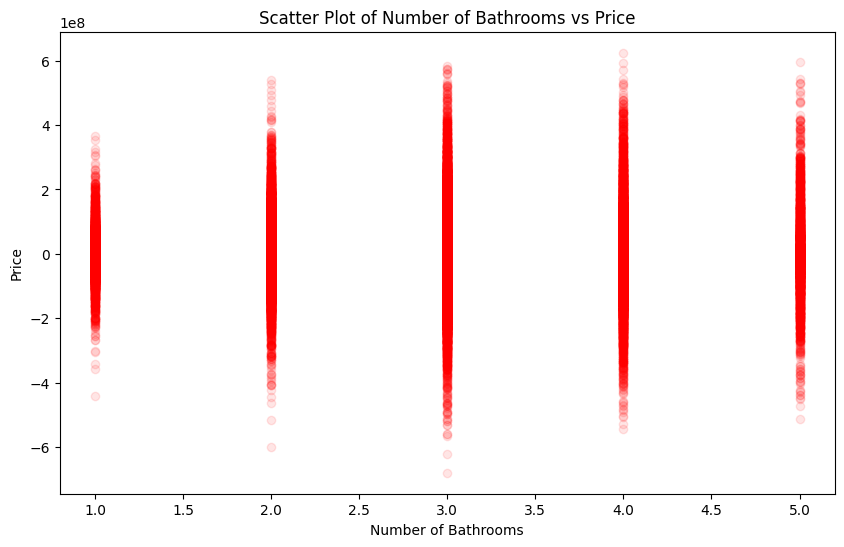

In [44]:
plt.figure(figsize=(10, 6))
# plt.scatter(df_results['habitaciones'], df_results['y_test'], alpha=0.5)
# plt.scatter(df_results['habitaciones'], df_results['y_pred'], alpha=0.1, c='yellow')
plt.scatter(df_results['habitaciones'], df_results['error'], alpha=0.1, c='red')

# Adding title and labels
plt.title('Scatter Plot of Number of Bathrooms vs Price')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Price')

# Show plot
plt.show()

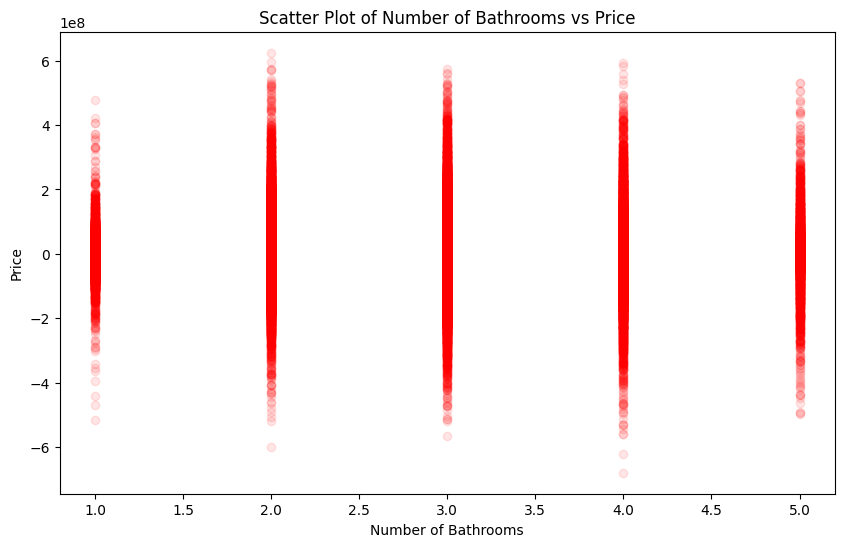

In [45]:
plt.figure(figsize=(10, 6))
# plt.scatter(df_results['banos'], df_results['y_test'], alpha=0.5)
# plt.scatter(df_results['banos'], df_results['y_pred'], alpha=0.1, c='red')
plt.scatter(df_results['banos'], df_results['error'], alpha=0.1, c='red')

# Adding title and labels
plt.title('Scatter Plot of Number of Bathrooms vs Price')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Price')

# Show plot
plt.show()

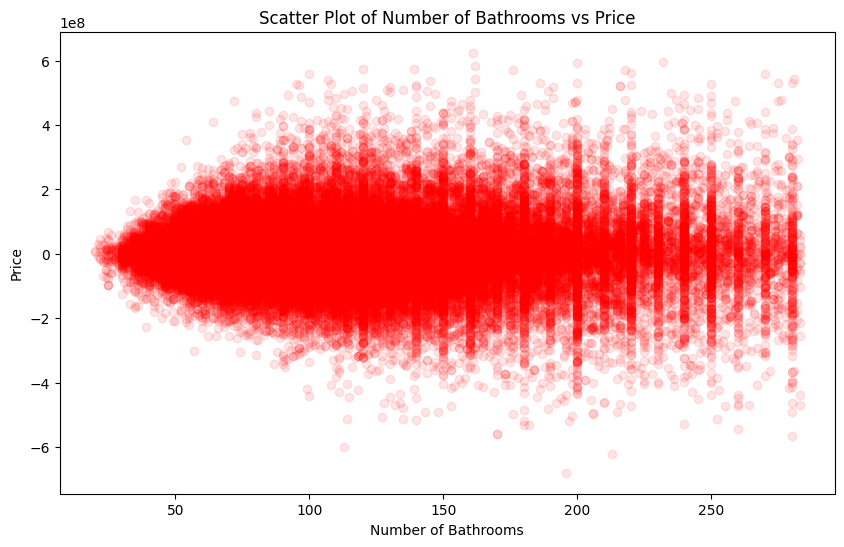

In [46]:
plt.figure(figsize=(10, 6))
# plt.scatter(df_results['area'], df_results['y_test'], alpha=0.5)
# plt.scatter(df_results['area'], df_results['y_pred'], alpha=0.1, c='red')
plt.scatter(df_results['area'], df_results['error'], alpha=0.1, c='red')

# Adding title and labels
plt.title('Scatter Plot of Number of Bathrooms vs Price')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Price')

# Show plot
plt.show()

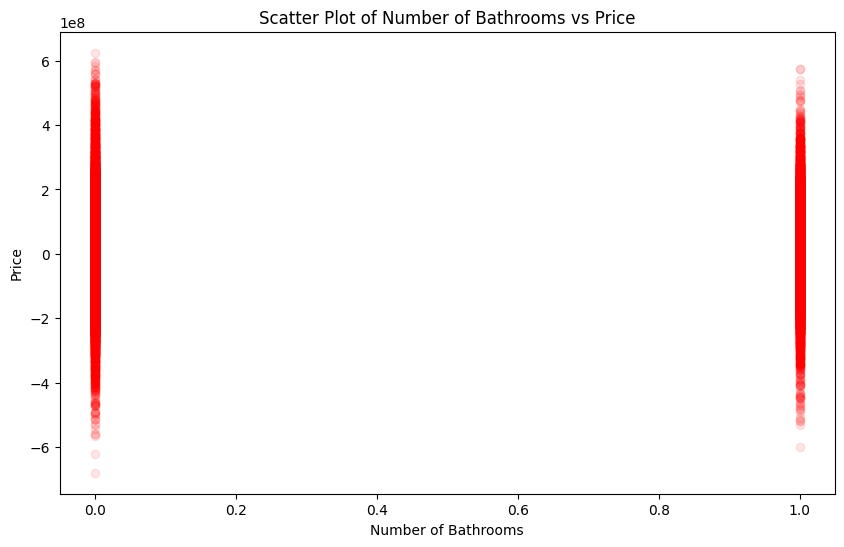

In [47]:
plt.figure(figsize=(10, 6))
# plt.scatter(df_results['num_ascensores'], df_results['y_test'], alpha=0.5)
# plt.scatter(df_results['num_ascensores'], df_results['y_pred'], alpha=0.1, c='red')
plt.scatter(df_results['num_ascensores'], df_results['error'], alpha=0.1, c='red')

# Adding title and labels
plt.title('Scatter Plot of Number of Bathrooms vs Price')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Price')

# Show plot
plt.show()

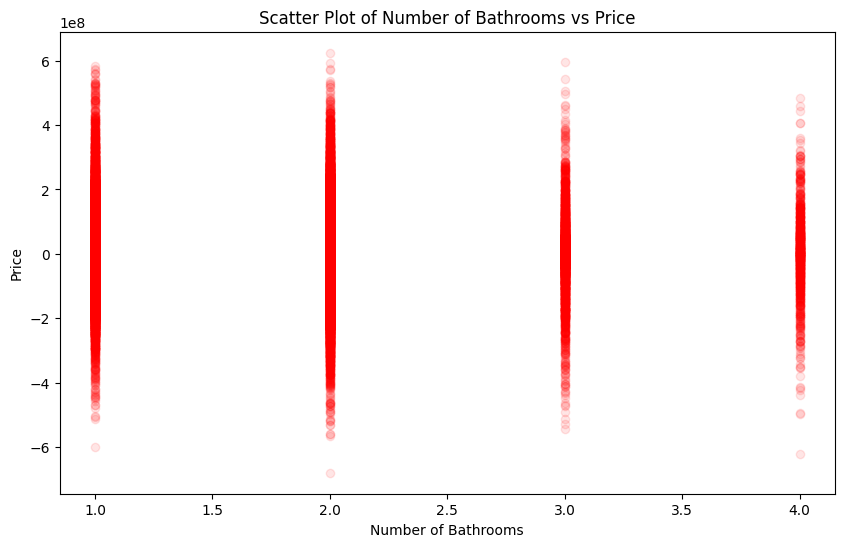

In [48]:
plt.figure(figsize=(10, 6))
# plt.scatter(df_results['garajes'], df_results['y_test'], alpha=0.5)
# plt.scatter(df_results['garajes'], df_results['y_pred'], alpha=0.1, c='red')
plt.scatter(df_results['garajes'], df_results['error'], alpha=0.1, c='red')

# Adding title and labels
plt.title('Scatter Plot of Number of Bathrooms vs Price')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Price')

# Show plot
plt.show()

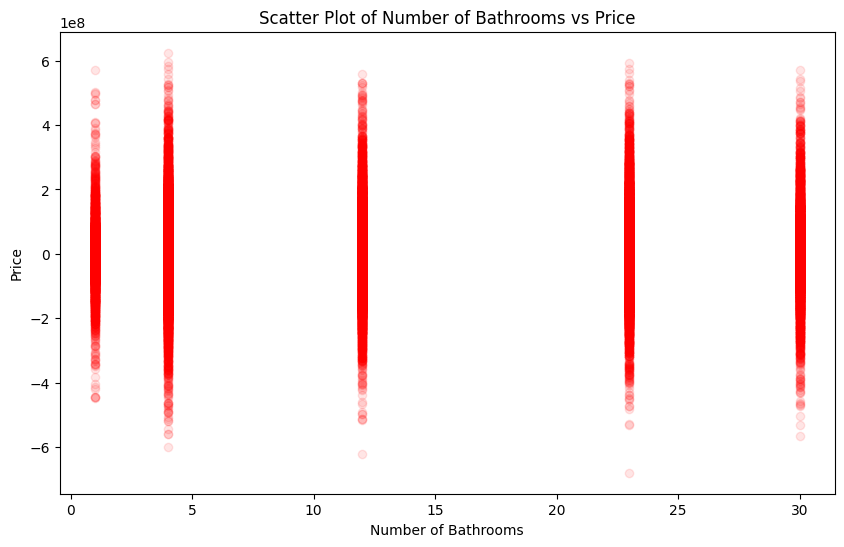

In [49]:
plt.figure(figsize=(10, 6))
# plt.scatter(df_results['anos_antiguedad'], df_results['y_test'], alpha=0.5)
# plt.scatter(df_results['anos_antiguedad'], df_results['y_pred'], alpha=0.1, c='red')
plt.scatter(df_results['anos_antiguedad'], df_results['error'], alpha=0.1, c='red')

# Adding title and labels
plt.title('Scatter Plot of Number of Bathrooms vs Price')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Price')

# Show plot
plt.show()

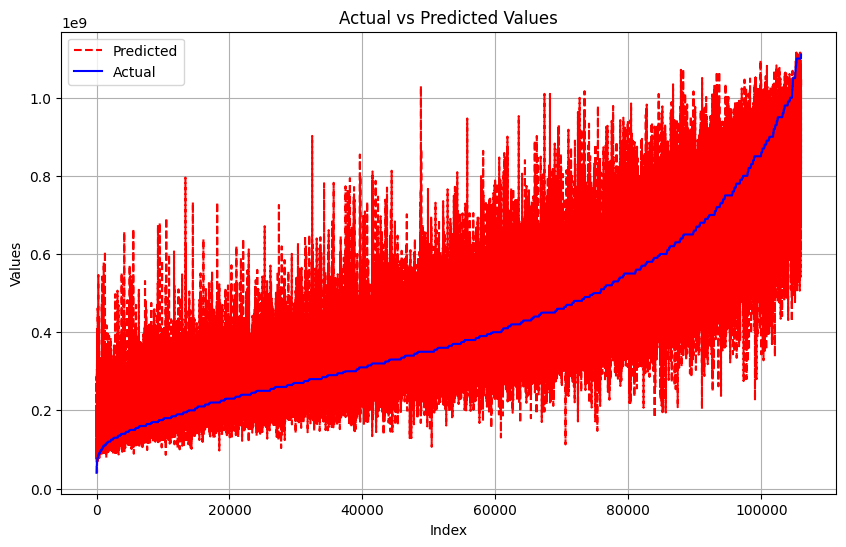

In [20]:
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df_results.index, df_results['y_pred'], label='Predicted', color='r', linestyle='--')
plt.plot(df_results.index, df_results['y_test'], label='Actual', color='b')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

### Precio M2

In [50]:
# Evaluating the model
mse = mean_squared_error(y_test_precio, y_pred_precio)
rmse = root_mean_squared_error(y_test_precio, y_pred_precio)
mape = mean_absolute_percentage_error(y_test_precio, y_pred_precio)
r2 = r2_score(y_test_precio, y_pred_precio)

print(f'Mean Squared Error (MSE): {"{:,}".format(mse)}')
print(f'Root Mean Squared Error (RMSE): {"{:,}".format(rmse)}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'R^2 Score: {r2}')

Mean Squared Error (MSE): 8,434,148,473,251,630.0
Root Mean Squared Error (RMSE): 91,837,620.14148466
Mean Absolute Percentage Error (MAPE): 0.17870844335130054
R^2 Score: 0.827621665668762


In [51]:
df_results = pd.DataFrame(
    {
        'y_test': y_test_precio,
        'y_pred': y_pred_precio,
    }
)
df_results.sort_values(by='y_test', ascending=True, inplace=True)
df_results.reset_index(drop=True, inplace=True)

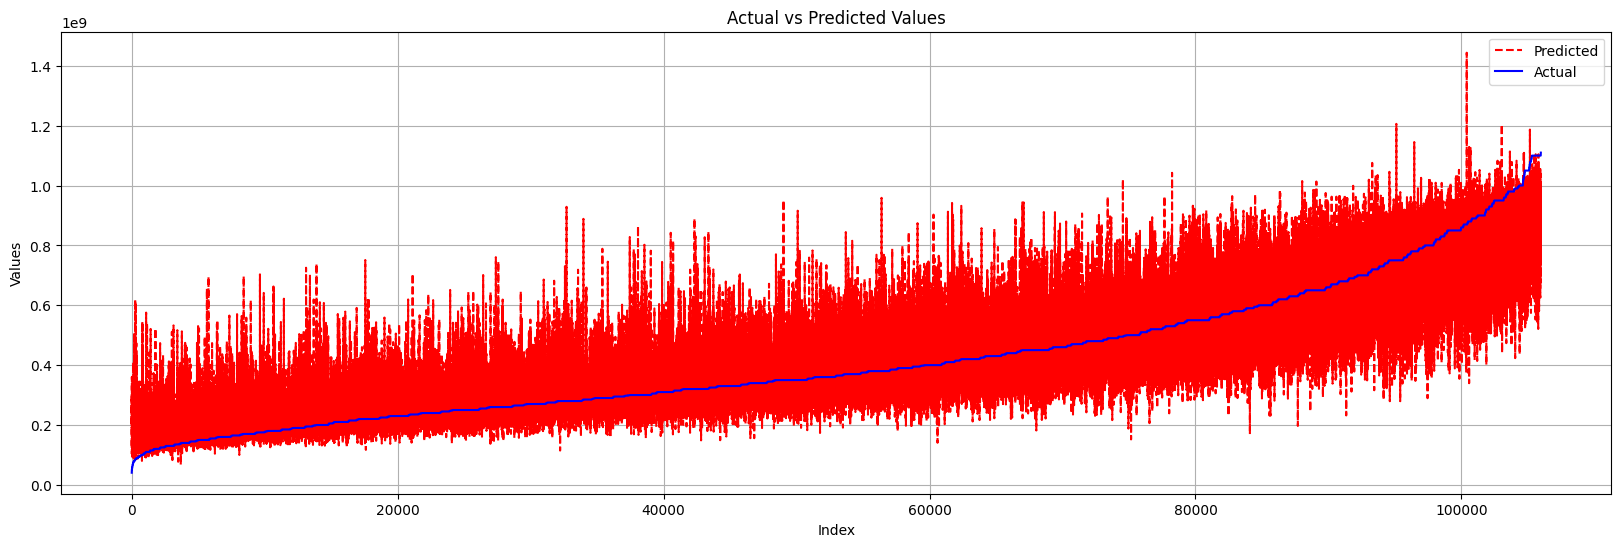

In [52]:
# Plotting the data
plt.figure(figsize=(20, 6))
plt.plot(df_results.index, df_results['y_pred'], label='Predicted', color='r', linestyle='--')
plt.plot(df_results.index, df_results['y_test'], label='Actual', color='b')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()